In [1]:
import numpy as np
import datetime
import cf_units
import xarray as xr
import os
import sys
import datetime as dt
import matplotlib as mpl
import copy

## plotting
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as colors
import numpy.ma as ma
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import mplotutils as mpu
import seaborn as sns

#loading data
from sklearn.externals import joblib


/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/utils/validation.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LARGE_SPARSE_SUPPORTED = LooseVersion(scipy_version) >= '0.14.0'


In [2]:
### set plot params

params = {'legend.fontsize': 'xx-large',
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'x-large',
          'figure.figsize': (9,5),
          "font.family": "serif",
         'ytick.labelsize':'x-large',
         "font.weight":"normal",
         "axes.labelweight":"normal"}
plt.rcParams.update(params)

## First the one degree data

In [4]:
## plot the observed land surface trend from BEST ORIGINAL dataset

#Get directory
dir_in_data_mod = '/home/tristan/mesmer/data/'
    
#prepare the inputs as array
BEST_data = 'BEST_1deg_datefix.nc'

# load in observation data
df_obs = xr.open_mfdataset(dir_in_data_mod+BEST_data)
df_obs

<xarray.Dataset>
Dimensions:      (longitude: 360, latitude: 180, time: 3265, month_number: 12)
Coordinates:
  * longitude    (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * latitude     (latitude) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * time         (time) datetime64[ns] 1750-01-31 1750-02-28 ... 2022-01-31
Dimensions without coordinates: month_number
Data variables:
    land_mask    (latitude, longitude) float64 dask.array<chunksize=(180, 360), meta=np.ndarray>
    temperature  (time, latitude, longitude) float32 dask.array<chunksize=(3265, 180, 360), meta=np.ndarray>
    climatology  (month_number, latitude, longitude) float32 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
Attributes:
    Conventions:          Berkeley Earth Internal Convention (based on CF-1.5)
    title:                Gridded Berkeley Earth Surface Temperature Anomaly ...
    history:              10-Feb-2022 17:30:05
    institution:          Berkeley Earth Surface Temperature Project
    source_file:          Complete_TAVG.50590s.20220210T171609.mat
    source_history:       07-Feb-2022 15:32:40
    source_code_version:  eead777c589734c11a431a21725e06d3
    comment:              This file contains surface temperature anomaly fiel...

In [3]:
df_obs = df_obs.where(df_obs.land_mask.values > 0.0)
data_test = np.squeeze(np.array([df_obs.temperature.values[1200:-1,:,:]]))
# print(data_test.shape)
y_all_mean = np.nanmean(data_test.reshape(-1,12,64800), axis=(1,2))
# print(y_all_mean.shape)
data_mean = np.nanmean(data_test, axis=(1,2))
# print(y_all_mean)

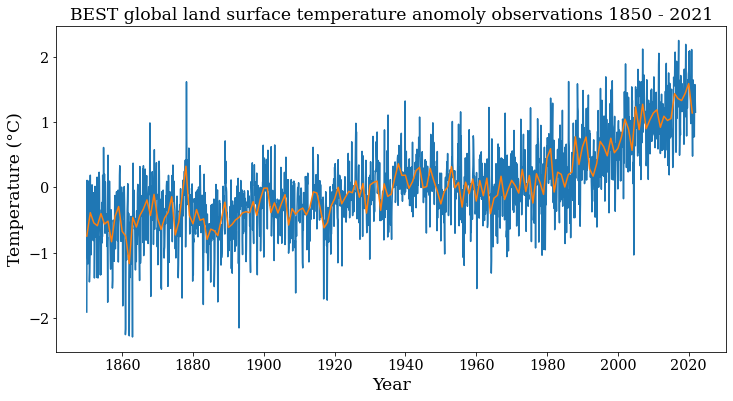

In [11]:
time = np.arange(np.datetime64('1850-01-15'), np.datetime64('2022-01-15'), dtype='datetime64[M]')
time2 = np.arange(np.datetime64('1850'), np.datetime64('2022'), dtype='datetime64[Y]')
fig, ax = plt.subplots(figsize=(12,6))
ax.set_title("BEST global land surface temperature anomoly observations 1850 - 2021")
ax.set_xlabel("Year")
ax.set_ylabel("Temperature (°C)")
ax.plot(time,
       data_mean)
ax.plot(time2,
       y_all_mean)
plt.show()

In [41]:
# now plot the yearly trend

y_all = np.mean(data_mean.reshape(12, 1))

ValueError: cannot reshape array of size 2064 into shape (12,1)

## test the other dataset

In [12]:
## plot the observed land surface trend from BEST ORIGINAL dataset

#Get directory
dir_in_data_mod = '/home/tristan/mesmer/data/'
    
#prepare the inputs as array
BEST_data = 'regrid_v3.nc'

# load in observation data
df_obs = xr.open_mfdataset(dir_in_data_mod+BEST_data)
df_obs

<xarray.Dataset>
Dimensions:      (time: 3265, lon: 144, lat: 72, month_number: 12)
Coordinates:
  * time         (time) datetime64[ns] 1750-01-31 1750-02-28 ... 2022-01-31
  * lon          (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat          (lat) float64 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
Dimensions without coordinates: month_number
Data variables:
    land_mask    (lat, lon) float64 dask.array<chunksize=(72, 144), meta=np.ndarray>
    temperature  (time, lat, lon) float32 dask.array<chunksize=(3265, 72, 144), meta=np.ndarray>
    climatology  (month_number, lat, lon) float32 dask.array<chunksize=(12, 72, 144), meta=np.ndarray>
Attributes:
    CDI:                  Climate Data Interface version 1.9.8 (https://mpime...
    history:              Tue May 31 20:29:20 2022: cdo remapcon2,r144x72 reg...
    institution:          Berkeley Earth Surface Temperature Project
    Conventions:          Berkeley Earth Internal Convention (based on CF-1.5)
    title:                Gridded Berkeley Earth Surface Temperature Anomaly ...
    source_file:          Complete_TAVG.50590s.20220210T171609.mat
    source_history:       07-Feb-2022 15:32:40
    source_code_version:  eead777c589734c11a431a21725e06d3
    comment:              This file contains surface temperature anomaly fiel...
    CDO:                  Climate Data Operators version 1.9.8 (https://mpime...

In [13]:
## add land mask
# load the land mask as frac_l
dir_in_geo_dist = '/home/tristan/mesmer/data/'
frac_l = xr.open_mfdataset(dir_in_geo_dist + 'interim_invariant_lsmask_regrid.nc', combine='by_coords',decode_times=False)

frac_l_raw = np.squeeze(copy.deepcopy(frac_l.lsm.values))  #land-sea mask of ERA-interim bilinearily interpolated 

frac_l = frac_l.where(frac_l.lat>-60,0)  # remove Antarctica from frac_l field (ie set frac l to 0)

idx_l=np.squeeze(frac_l.lsm.values)>0.0 # idx_l = index land -> idex land #-> everything >0 we consider as land
##

In [14]:
data_test = np.squeeze(np.array([df_obs.temperature.values[:,idx_l]])) 
data_test = data_test.reshape(2064,idx_l.sum())

#annual mean for the regridded data
regrid_yr_mean = np.nanmean(data_test.reshape(-1,12,idx_l.sum()), axis=(1))
#annual mean across all grid points
regrid_yr_mean = np.nanmean(regrid_yr_mean, axis=1)

data_mean_regrid = np.nanmean(data_test, axis=(1))


regrid_yr_mean.shape

ValueError: cannot reshape array of size 9935395 into shape (2064,3043)

## now the 2.5 degree data

In [15]:
## plot the observed land surface trend from BEST ORIGINAL dataset

## add land mask
# load the land mask as frac_l
dir_in_geo_dist = '/home/tristan/mesmer/data/'
frac_l = xr.open_mfdataset(dir_in_geo_dist + 'interim_invariant_lsmask_regrid.nc', combine='by_coords',decode_times=False)

frac_l_raw = np.squeeze(copy.deepcopy(frac_l.lsm.values))  #land-sea mask of ERA-interim bilinearily interpolated 

frac_l = frac_l.where(frac_l.lat>-60,0)  # remove Antarctica from frac_l field (ie set frac l to 0)

idx_l=np.squeeze(frac_l.lsm.values)>0.0 # idx_l = index land -> idex land #-> everything >0 we consider as land
##

#Get directory
dir_in_data_mod = '/home/tristan/mesmer/data/'
    
#prepare the inputs as array
BEST_data = 'obs_data_25.nc'

# load in observation data
df_obs = xr.open_mfdataset(dir_in_data_mod+BEST_data)

In [16]:
data_test = np.squeeze(np.array([df_obs.temperature.values[:,idx_l]])) 
data_test = data_test.reshape(2064,idx_l.sum())

#annual mean for the regridded data
regrid_yr_mean = np.nanmean(data_test.reshape(-1,12,idx_l.sum()), axis=(1))
#annual mean across all grid points
regrid_yr_mean = np.nanmean(regrid_yr_mean, axis=1)

data_mean_regrid = np.nanmean(data_test, axis=(1))


regrid_yr_mean.shape

/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """


(172,)

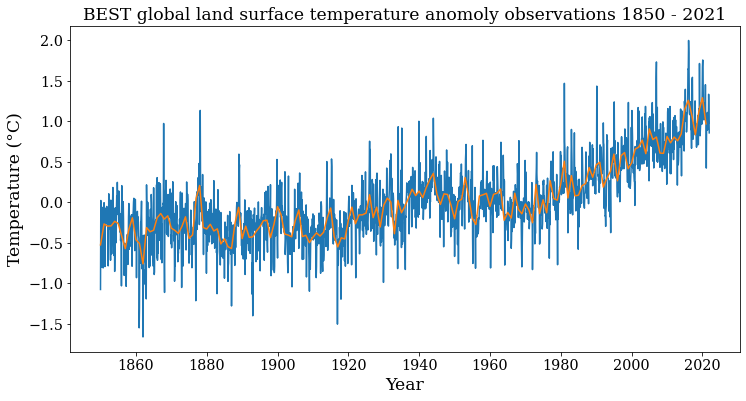

In [18]:
time = np.arange(np.datetime64('1850-01-15'), np.datetime64('2022-01-15'), dtype='datetime64[M]')
time2 = np.arange(np.datetime64('1850'), np.datetime64('2022'), dtype='datetime64[Y]')
fig, ax = plt.subplots(figsize=(12,6))

ax.set_title("BEST global land surface temperature anomoly observations 1850 - 2021")
ax.set_xlabel("Year")
ax.set_ylabel("Temperature (°C)")

ax.plot(time,
       data_mean_regrid)

ax.plot(time2,
       regrid_yr_mean)

plt.show()

## Now plot them both together

/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: Mean of empty slice


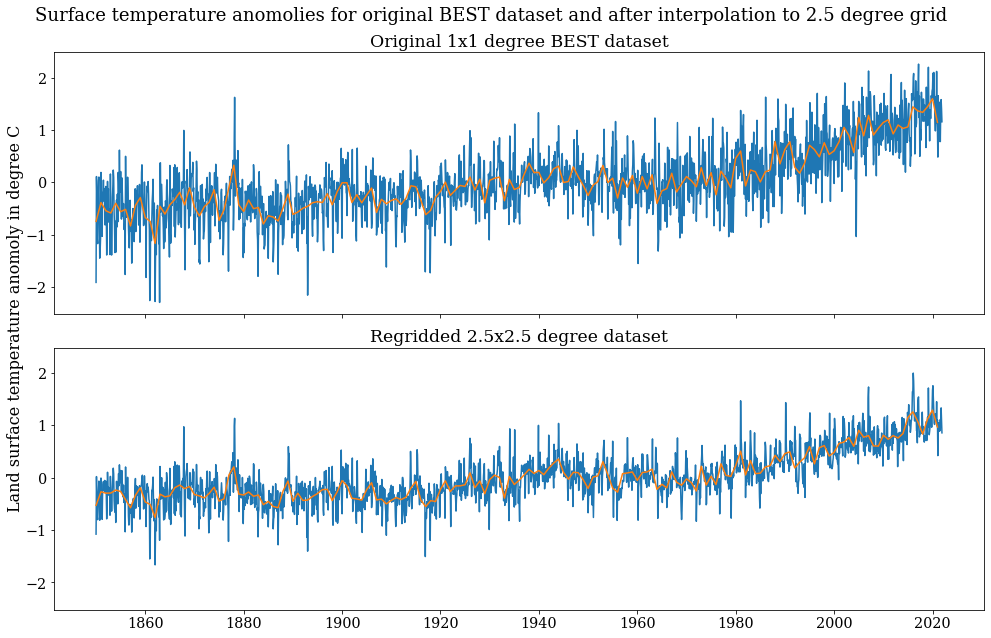

In [19]:
dir_in_data_mod = '/home/tristan/mesmer/data/'
    
#prepare the inputs as array
BEST_data = 'BEST_1deg_datefix.nc'
Regrid_data = 'obs_data_25.nc'
# load in observation data
df_obs = xr.open_mfdataset(dir_in_data_mod+BEST_data)
df_regrid = xr.open_mfdataset(dir_in_data_mod+Regrid_data)

## add land mask
# load the land mask as frac_l
dir_in_geo_dist = '/home/tristan/mesmer/data/'
frac_l = xr.open_mfdataset(dir_in_geo_dist + 'interim_invariant_lsmask_regrid.nc', combine='by_coords',decode_times=False)

frac_l_raw = np.squeeze(copy.deepcopy(frac_l.lsm.values))  #land-sea mask of ERA-interim bilinearily interpolated 

frac_l = frac_l.where(frac_l.lat>-60,0)  # remove Antarctica from frac_l field (ie set frac l to 0)

idx_l=np.squeeze(frac_l.lsm.values)>0.0 # idx_l = index land -> idex land #-> everything >0 we consider as land
##

## calculations for the original one degree dataset 
df_obs = df_obs.where(df_obs.land_mask.values > 0.0) ## apply land mask
data_test = np.squeeze(np.array([df_obs.temperature.values[1200:-1,:,:]])) ## monthly means across all gridpoints
y_all_mean = np.nanmean(data_test.reshape(-1,12,64800), axis=(1,2))  # annual means
data_mean = np.nanmean(data_test, axis=(1,2))   # annual mean values across all gridpoints

## calculations for the regridded data
data_regrid = np.squeeze(np.array([df_regrid.temperature.values[:,idx_l]])) 
data_regrid = data_regrid.reshape(2064,idx_l.sum()) ## apply land mask
data_mean_regrid = np.nanmean(data_regrid, axis=(1)) ##monhtly means across all gridpoints
regrid_yr_mean = np.nanmean(data_regrid.reshape(-1,12,idx_l.sum()), axis=(1)) #annual mean for the regridded data
regrid_yr_mean = np.nanmean(regrid_yr_mean, axis=1)  #annual mean across all grid points

### start plotting

#first set times for x-axes
time = np.arange(np.datetime64('1850-01-15'), np.datetime64('2022-01-15'), dtype='datetime64[M]')
time2 = np.arange(np.datetime64('1850'), np.datetime64('2022'), dtype='datetime64[Y]')


fig, (ax1,ax2) = plt.subplots(2, figsize=(14,9), sharex=True, sharey=True)
fig.suptitle("Surface temperature anomolies for original BEST dataset and after interpolation to 2.5 degree grid", fontsize=18)
fig.supylabel("Land surface temperature anomoly in degree C", fontsize=16)
ax1.plot(time,
       data_mean)
ax1.plot(time2,
       y_all_mean)
ax1.set(title="Original 1x1 degree BEST dataset")

ax2.plot(time,
       data_mean_regrid)
ax2.plot(time2,
       regrid_yr_mean)
ax2.set(title="Regridded 2.5x2.5 degree dataset")

plt.tight_layout()
plt.show()


## try one degree data again

In [3]:
## plot the observed land surface trend from BEST ORIGINAL dataset

#Get directory
dir_in_data_mod = '/home/tristan/mesmer/data/'
    
#prepare the inputs as array
BEST_data = 'full_earth.nc'

# load in observation data
df_obs = xr.open_mfdataset(dir_in_data_mod+BEST_data)
df_obs

<xarray.Dataset>
Dimensions:      (longitude: 360, latitude: 180, time: 2064, month_number: 12)
Coordinates:
  * longitude    (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * latitude     (latitude) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * time         (time) float64 1.85e+03 1.85e+03 ... 2.022e+03 2.022e+03
Dimensions without coordinates: month_number
Data variables:
    land_mask    (latitude, longitude) float64 dask.array<chunksize=(180, 360), meta=np.ndarray>
    temperature  (time, latitude, longitude) float32 dask.array<chunksize=(2064, 180, 360), meta=np.ndarray>
    climatology  (month_number, latitude, longitude) float32 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
Attributes:
    Conventions:  Berkeley Earth Internal Convention (based on CF-1.5)
    title:        Native Format Berkeley Earth Surface Temperature Anomaly Field
    institution:  Berkeley Earth Surface Temperature Project
    comment:      This file contains surface temperature anomaly field gridde...

In [4]:
def cos_wgt(ds, lat_string):
    
    from numpy import cos, deg2rad
    if lat_string == 'latitude':
        weights = np.cos(np.deg2rad(ds.latitude))
        
    else:
        weights = np.cos(np.deg2rad(ds.lat))
    
    return weights

wgt = cos_wgt(df_obs, 'latitude')
wgt

<xarray.DataArray 'latitude' (latitude: 180)>
array([0.00872656, 0.02617699, 0.04361945, 0.06104851, 0.07845908,
       0.09584576, 0.11320324, 0.13052624, 0.14780948, 0.16504757,
       0.18223551, 0.19936794, 0.21643965, 0.23344542, 0.25037998,
       0.26723838, 0.28401536, 0.30070582, 0.3173047 , 0.33380693,
       0.35020736, 0.3665012 , 0.38268346, 0.3987491 , 0.4146933 ,
       0.43051115, 0.44619778, 0.4617486 , 0.47715878, 0.49242356,
       0.5075384 , 0.5224986 , 0.5372996 , 0.551937  , 0.56640625,
       0.58070296, 0.59482276, 0.6087614 , 0.62251467, 0.6360782 ,
       0.64944804, 0.66262007, 0.67559016, 0.68835455, 0.70090926,
       0.71325046, 0.72537434, 0.7372773 , 0.7489557 , 0.76040596,
       0.77162457, 0.78260815, 0.7933533 , 0.8038569 , 0.8141155 ,
       0.8241262 , 0.83388585, 0.8433914 , 0.85264015, 0.8616291 ,
       0.87035567, 0.87881714, 0.8870108 , 0.89493436, 0.90258527,
       0.9099613 , 0.9170601 , 0.9238795 , 0.9304176 , 0.9366722 ,
       0.9426415 , 0.94832367, 0.95371693, 0.95881975, 0.96363044,
       0.96814764, 0.9723699 , 0.976296  , 0.9799247 , 0.9832549 ,
       0.9862856 , 0.9890159 , 0.9914449 , 0.9935719 , 0.9953962 ,
       0.9969173 , 0.9981348 , 0.99904823, 0.99965733, 0.9999619 ,
       0.9999619 , 0.99965733, 0.99904823, 0.9981348 , 0.9969173 ,
       0.9953962 , 0.9935719 , 0.9914449 , 0.9890159 , 0.9862856 ,
       0.9832549 , 0.9799247 , 0.976296  , 0.9723699 , 0.96814764,
       0.96363044, 0.95881975, 0.95371693, 0.94832367, 0.9426415 ,
       0.9366722 , 0.9304176 , 0.9238795 , 0.9170601 , 0.9099613 ,
       0.90258527, 0.89493436, 0.8870108 , 0.87881714, 0.87035567,
       0.8616291 , 0.85264015, 0.8433914 , 0.83388585, 0.8241262 ,
       0.8141155 , 0.8038569 , 0.7933533 , 0.78260815, 0.77162457,
       0.76040596, 0.7489557 , 0.7372773 , 0.72537434, 0.71325046,
       0.70090926, 0.68835455, 0.67559016, 0.66262007, 0.64944804,
       0.6360782 , 0.62251467, 0.6087614 , 0.59482276, 0.58070296,
       0.56640625, 0.551937  , 0.5372996 , 0.5224986 , 0.5075384 ,
       0.49242356, 0.47715878, 0.4617486 , 0.44619778, 0.43051115,
       0.4146933 , 0.3987491 , 0.38268346, 0.3665012 , 0.35020736,
       0.33380693, 0.3173047 , 0.30070582, 0.28401536, 0.26723838,
       0.25037998, 0.23344542, 0.21643965, 0.19936794, 0.18223551,
       0.16504757, 0.14780948, 0.13052624, 0.11320324, 0.09584576,
       0.07845908, 0.06104851, 0.04361945, 0.02617699, 0.00872656],
      dtype=float32)
Coordinates:
  * latitude  (latitude) float32 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
Attributes:
    units:          degrees_north
    standard_name:  latitude
    long_name:      Latitude

In [6]:
df_weighted = df_obs.weighted(wgt)

In [7]:
df_weighted_mean = df_weighted.mean(("latitude", "longitude"))
df_weighted_mean

<xarray.Dataset>
Dimensions:      (time: 2064, month_number: 12)
Coordinates:
  * time         (time) float64 1.85e+03 1.85e+03 ... 2.022e+03 2.022e+03
Dimensions without coordinates: month_number
Data variables:
    land_mask    float64 dask.array<chunksize=(), meta=np.ndarray>
    temperature  (time) float32 dask.array<chunksize=(2064,), meta=np.ndarray>
    climatology  (month_number) float32 dask.array<chunksize=(12,), meta=np.ndarray>

In [71]:
## add land mask
# load the land mask as frac_l
dir_in_geo_dist = '/home/tristan/mesmer/data/'
frac_l = xr.open_mfdataset(dir_in_geo_dist + 't2m_land.nc', combine='by_coords',decode_times=False)
frac_l_raw = np.squeeze(copy.deepcopy(frac_l.land_mask.values)) #land-sea mask of ERA-interim bilinearily interpolated 

frac_l_raw.shape

frac_l = frac_l.where(frac_l.latitude>-60,0)  # remove Antarctica from frac_l field (ie set frac l to 0)
idx_l_org=np.squeeze(frac_l.land_mask.values)>0.0 # idx_l = index land -> idex land #-> everything >0 we consider as land
# ##
lon_pc, lat_pc = mpu.infer_interval_breaks(frac_l.longitude, frac_l.latitude) # the lon / lat for the plotting with pcolormesh

In [9]:
df_obs_np = np.array(df_weighted_mean['temperature'])

print(df_obs_np.shape)

df_obs_smooth = df_weighted_mean.rolling(time=12*5, center=True).mean()
df_obs_smooth = np.array(df_obs_smooth['temperature'])

print(df_obs_smooth.shape)

(2064,)
(2064,)


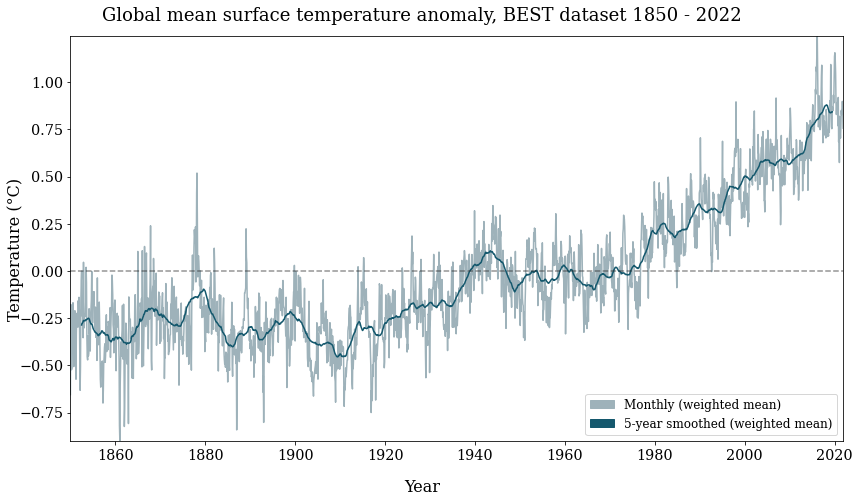

In [39]:
time = np.arange(np.datetime64('1850-01-15'), np.datetime64('2022-01-15'), dtype='datetime64[M]')
time2 = np.arange(np.datetime64('1850'), np.datetime64('2022'), dtype='datetime64[Y]')

fig, ax = plt.subplots(figsize=(12,7))
fig.suptitle("Global mean surface temperature anomaly, BEST dataset 1850 - 2022", fontsize=18)
fig.supylabel("Temperature (°C)", fontsize=16)
fig.supxlabel("Year", fontsize=16)

#create legend
monthly_vals = mpatches.Patch(color="#9EB2BA", label="Monthly (weighted mean)")
obs_yr_vals = mpatches.Patch(color="#14586D", label="5-year smoothed (weighted mean)")


ax.plot(time,
       df_obs_np,
        color="#9EB2BA")
ax.plot(time,
       df_obs_smooth,
        color="#14586D")

plt.axhline(y=0, color='#2a2a2a', linestyle='--', alpha=0.5)

ax.legend(handles=[monthly_vals, obs_yr_vals], loc="lower right", prop={'size': 12})


plt.tight_layout()
plt.margins(x=0, y=0)
plt.show()

## plot the two together

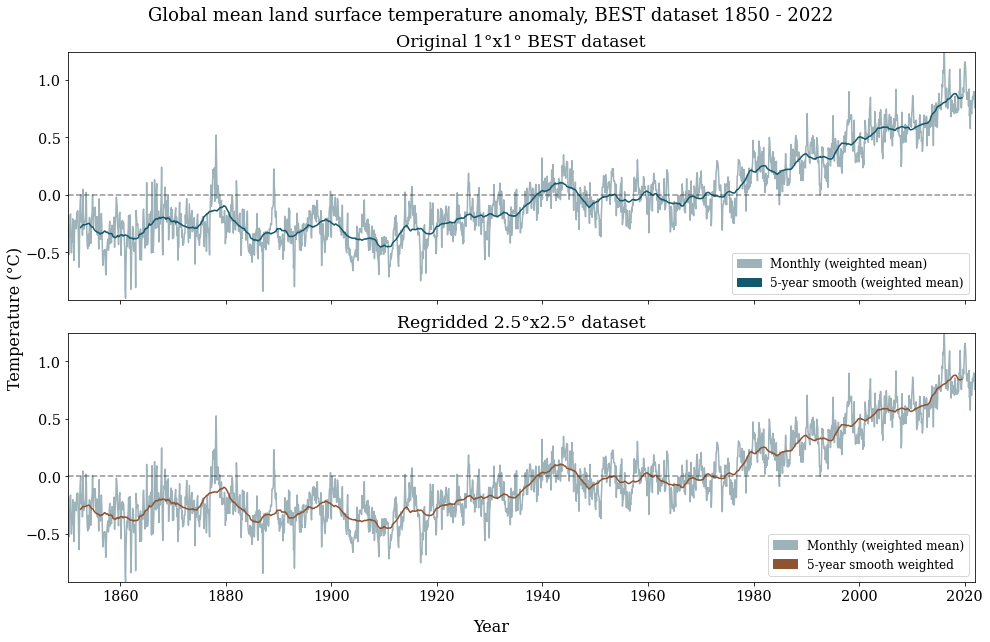

In [33]:
dir_in_data_mod = '/home/tristan/mesmer/data/'
    
#prepare the inputs as array
BEST_data = 'full_earth.nc'
Regrid_data = 'obs_data_25.nc'

# load in full Earth observation data
df_obs = xr.open_mfdataset(dir_in_data_mod+BEST_data)
df_regrid = xr.open_mfdataset(dir_in_data_mod+Regrid_data)

wgt_obs = cos_wgt(df_obs, 'latitude')
wgt_regrid = cos_wgt(df_regrid, 'lat')

df_obs_weighted = df_obs.weighted(wgt_obs)
df_regrid_weighted = df_regrid.weighted(wgt_regrid)

df_obs_weighted_mean = df_obs_weighted.mean(("latitude", "longitude"))
df_regrid_weighted_mean = df_regrid_weighted.mean(("lat", "lon"))

df_obs_smooth = df_obs_weighted_mean.rolling(time=12*5, center=True).mean()
df_regrid_smooth = df_regrid_weighted_mean.rolling(time=12*5, center=True).mean()

df_obs_np = np.array(df_obs_weighted_mean['temperature'])
df_regrid_np = np.array(df_regrid_weighted_mean['temperature'])

df_obs_smooth_np = np.array(df_obs_smooth['temperature'])
df_regrid_smooth_np = np.array(df_regrid_smooth['temperature'])

### start plotting

#first set times for x-axes
time = np.arange(np.datetime64('1850-01-15'), np.datetime64('2022-01-15'), dtype='datetime64[M]')
# time2 = np.arange(np.datetime64('1850'), np.datetime64('2022'), dtype='datetime64[Y]')

fig, (ax1,ax2) = plt.subplots(2, figsize=(14,9), sharex=True, sharey=True)
fig.suptitle("Global mean land surface temperature anomaly, BEST dataset 1850 - 2022", fontsize=18)
fig.supylabel("Temperature (°C)", fontsize=16)
fig.supxlabel("Year", fontsize=16)

#create legend
monthly_vals = mpatches.Patch(color="#9EB2BA", label="Monthly (weighted mean)")
obs_yr_vals = mpatches.Patch(color="#14586D", label="5-year smooth (weighted mean)")
regrid_yr_vals = mpatches.Patch(color="#8E5330", label="5-year smooth weighted")

ax1.plot(time,
       df_obs_np,
        color="#9EB2BA")
ax1.plot(time,
       df_obs_smooth_np,
        color="#14586D")
ax1.set(title="Original 1°x1° BEST dataset")
ax1.legend(handles=[monthly_vals, obs_yr_vals], loc="lower right", prop={'size': 12})
ax1.axhline(y=0, color='#2a2a2a', linestyle='--', alpha=0.5)

ax2.plot(time,
       df_regrid_np,
        color="#9EB2BA")
ax2.plot(time,
       df_regrid_smooth_np,
        color="#8E5330")
ax2.set(title="Regridded 2.5°x2.5° dataset")
ax2.legend(handles=[monthly_vals, regrid_yr_vals], loc="lower right", prop={'size': 12})
ax2.axhline(y=0, color='#2a2a2a', linestyle='--', alpha=0.5)

# annual_avg = mpatches.Patch(color=)

plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()


In [2]:
dir_in_data_mod = '/home/tristan/mesmer/data/'
Regrid_data = 'obs_data_25.nc'
df_regrid = xr.open_mfdataset(dir_in_data_mod+Regrid_data)

df_regrid

<xarray.Dataset>
Dimensions:      (time: 2064, lon: 144, lat: 72, month_number: 12)
Coordinates:
  * time         (time) datetime64[ns] 1850-01-15 1850-01-15 ... 2021-01-15
  * lon          (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat          (lat) float64 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
Dimensions without coordinates: month_number
Data variables:
    land_mask    (lat, lon) float64 dask.array<chunksize=(72, 144), meta=np.ndarray>
    temperature  (time, lat, lon) float32 dask.array<chunksize=(2064, 72, 144), meta=np.ndarray>
    climatology  (month_number, lat, lon) float32 dask.array<chunksize=(12, 72, 144), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 1.9.8 (https://mpimet.mpg.de...
    history:      Tue May 10 16:31:50 2022: cdo setday,15 obs_data_25_calende...
    institution:  Berkeley Earth Surface Temperature Project
    Conventions:  Berkeley Earth Internal Convention (based on CF-1.5)
    title:        Native Format Berkeley Earth Surface Temperature Anomaly Field
    comment:      This file contains surface temperature anomaly field gridde...
    CDO:          Climate Data Operators version 1.9.8 (https://mpimet.mpg.de...

In [231]:
# load the land mask as frac_l
dir_in_geo_dist = '/home/tristan/mesmer/data/'
frac_l = xr.open_mfdataset(dir_in_geo_dist + 'interim_invariant_lsmask_regrid.nc', combine='by_coords',decode_times=False)

frac_l_raw = np.squeeze(copy.deepcopy(frac_l.lsm.values))  #land-sea mask of ERA-interim bilinearily interpolated 

frac_l = frac_l.where(frac_l.lat>-60,0)  # remove Antarctica from frac_l field (ie set frac l to 0)

idx_l=np.squeeze(frac_l.lsm.values)>0.0 # idx_l = index land -> idex land #-> everything >0 we consider as land

lon_pc, lat_pc = mpu.infer_interval_breaks(frac_l.lon, frac_l.lat)  ## is this needed??

/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/ipykernel_launcher.py:65: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().


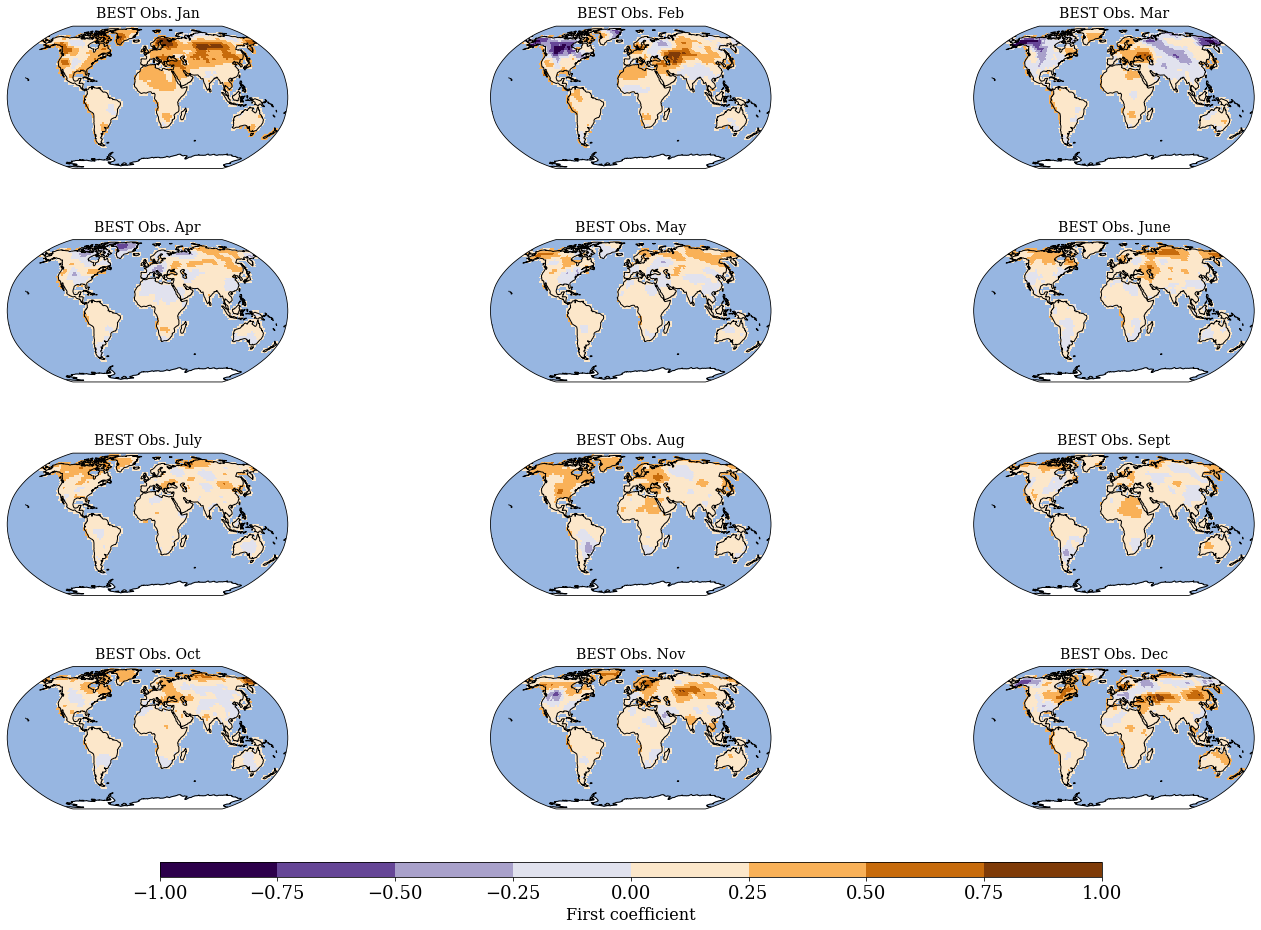

In [234]:
dir_in_data_mod = '/home/tristan/mesmer/output/'
coeffs_temp = joblib.load(dir_in_data_mod+'AR(1)_coeffs.pkl')
coeff_1 = coeffs_temp[1,:,:]

plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'mathtext.default':'regular'})
plt.rcParams.update({'mathtext.default':'it'})

months = ['Jan','Feb','Mar','Apr','May','June','July','Aug','Sept','Oct','Nov','Dec']

# white = np.array([248/256, 230/256, 200/256, 1])
# blue = np.array([30/256, 70/256, 130/256, 1])
# colors = np.vstack((white,blue))

# mymap = mpl.colors.LinearSegmentedColormap.from_list('my_colormap', colors, N=3)
# bounds = [ -1.5, 0.5, 1.5]
# norm = mpl.colors.BoundaryNorm(bounds, mymap.N)

bounds = np.array([-1.0, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1.0])
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
cmap = plt.cm.get_cmap('PuOr_r')

n_col = 3
n_row = 4

fs_title=16

fig=plt.figure(figsize=(n_col*14, n_row * 18))

grid = plt.GridSpec(n_row*13+3, n_col*15+4, wspace=1, hspace=0) 

# create a grid for the subplots #0.12

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

for i in range(12):    
    if i%3==0:
        i_y=0
        ax = plt.subplot(grid[i+1:i+3,i_y:i_y*10+10], projection=ccrs.Robinson(central_longitude=0))
        
    else:
        ax = plt.subplot(grid[i-(i%3)+1:i-(i%3)+3,i_y*10:i_y*10+10], projection=ccrs.Robinson(central_longitude=0))
            
    i_y+=1
    
    y_ma = np.zeros(idx_l.shape)
    y_ma = ma.masked_array(y_ma, mask=idx_l==False)

    coeff = coeff_1[i,:]
    
    y_ma[idx_l] = coeff
    
    
#     ax.set_title('BEST Obs', months[i])
    ax.set_title('BEST Obs. %s' %months[i],y=1.02,fontsize=14)
    
    axcbar = plt.subplot(grid[i-(i%3)+3:i-(i%3)+4,5:25])
    mesh_1=ax.pcolormesh(lon_pc, lat_pc, y_ma,  cmap=cmap, vmin=-1.0,vmax=1.0,transform=ccrs.PlateCarree(), norm=norm, rasterized=True)
    ax.add_feature(cfeature.OCEAN)

    plt.axis('off')

    ax.coastlines()

cbar=plt.colorbar(mesh_1, orientation='horizontal', fraction=0.25, aspect=65, ticks=([-1.0, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1.0]))
cbar.ax.tick_params(labelsize=18)
cbar.set_label('First coefficient',fontsize=16)
plt.show()

In [33]:
## Plot temperature anomolies

## plot the observed land surface trend from BEST ORIGINAL dataset

#Get directory
dir_in_data_mod = '/home/tristan/mesmer/data/'
    
#prepare the inputs as array
BEST_data = 'full_earth.nc'

# load in observation data
df_obs = xr.open_mfdataset(dir_in_data_mod+BEST_data)
time = df_obs.time.values
time.shape

(2064,)

In [40]:
## apply landmask
dir_in_geo_dist = '/home/tristan/mesmer/data/'
frac_l = xr.open_mfdataset(dir_in_geo_dist + 't2m_land.nc', combine='by_coords',decode_times=False)
frac_l_raw = np.squeeze(copy.deepcopy(frac_l.land_mask.values))  #land-sea mask of ERA-interim bilinearily interpolated 
frac_l = frac_l.where(frac_l.latitude>-60,0)  # remove Antarctica from frac_l field (ie set frac l to 0)
idx_l_org=np.squeeze(frac_l.land_mask.values)>0.0 # idx_l = index land -> idex land #-> everything >0 we consider as land
lon_pc, lat_pc = mpu.infer_interval_breaks(frac_l.longitude, frac_l.latitude)  ## is this needed??


In [37]:
data_1910 = np.squeeze(np.array([df_obs.temperature.values[720:732,:]])) ## select July of 1910
print(data_1910.shape)

mean_1910 = np.squeeze(np.nanmean(data_1910.reshape(-1,12,180,360), axis=(1))) #annual mean for the regridded data


(12, 180, 360)


/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  if sys.path[0] == '':


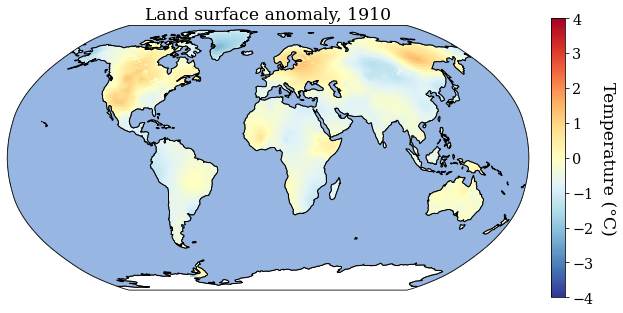

In [39]:
fig = plt.figure(figsize=(10,20))
ax=fig.add_subplot(1,1,1,projection=ccrs.Robinson(central_longitude=0))


mesh_1=ax.pcolormesh(lon_pc, lat_pc, mean_1910, cmap=plt.cm.get_cmap('RdYlBu_r'),transform=ccrs.PlateCarree(),rasterized=True, vmin=-4, vmax=4)

ax.coastlines()
ax.add_feature(cfeature.OCEAN, zorder=100, edgecolor='k')
cbar = plt.colorbar(mesh_1, fraction=0.025, pad=0.04)
cbar.set_label("Temperature (°C)", rotation=270, labelpad=23)
ax.set_title("Land surface anomaly, 1910")
plt.tight_layout()
plt.show()

In [41]:
data_2018 = np.squeeze(np.array([df_obs.temperature.values[2016:2028,:]])) ## select July of 1910
print(data_1910.shape)

mean_2018 = np.squeeze(np.nanmean(data_2018.reshape(-1,12,180,360), axis=(1))) #annual mean for the regridded data

(12, 180, 360)


/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  


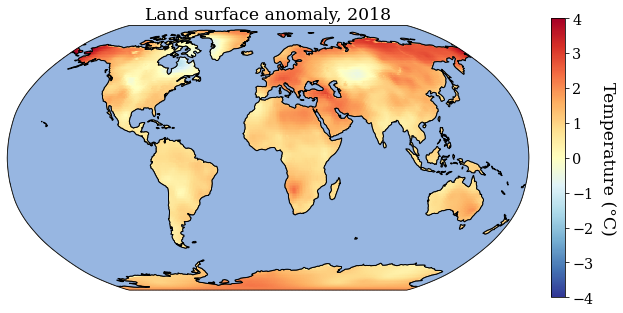

In [42]:
fig = plt.figure(figsize=(10,20))


ax=fig.add_subplot(1,1,1,projection=ccrs.Robinson(central_longitude=0))


mesh_1=ax.pcolormesh(lon_pc, lat_pc, mean_2018, cmap=plt.cm.get_cmap('RdYlBu_r'),transform=ccrs.PlateCarree(),rasterized=True, vmin=-4, vmax=4)

ax.coastlines()
ax.add_feature(cfeature.OCEAN, zorder=100, edgecolor='k')
cbar = plt.colorbar(mesh_1, fraction=0.025, pad=0.04)
cbar.set_label("Temperature (°C)", rotation=270, labelpad=23)
ax.set_title("Land surface anomaly, 2018")
plt.tight_layout()
plt.show()

In [43]:
dir_in_data_mod = '/home/tristan/mesmer/data/'
    
#prepare the inputs as array
Regrid_data = 'obs_data_25.nc'

# load in full Earth observation data
df = xr.open_mfdataset(dir_in_data_mod+Regrid_data)
df_test = df.temperature.values[2016:2028,:]

wgt_regrid = cos_wgt(df_test, 'lat')
df_regrid_weighted = df_test.weighted(wgt_regrid)
df_test_weighted_mean = df_regrid_weighted.mean(("latitude", "longitude"))


df_obs_smooth = df_obs_weighted_mean.rolling(time=12*5, center=True).mean()
df_regrid_smooth = df_regrid_weighted_mean.rolling(time=12*5, center=True).mean()

df_obs_np = np.array(df_obs_weighted_mean['temperature'])
df_regrid_np = np.array(df_regrid_weighted_mean['temperature'])

df_obs_smooth_np = np.array(df_obs_smooth['temperature'])
df_regrid_smooth_np = np.array(df_regrid_smooth['temperature'])

-7.475068